# Jigsaw Unintended Bias in Toxicity Classification
### Detect toxicity across a diverse range of conversations



***Nicolas Hubert***

This dataset comes from the following Kaggle challenge : https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data.
The key objective of this challenge is to design machine learning models so that they can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

We will mostly use this dataset to experiment with NB-SVM model, presented by Sida Wang and Christopher D. Manning in the following paper : https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf.

In [1]:
import pandas as pd, numpy as np
import re, string
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [4]:
df_train['comment_text'][3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [5]:
df_train.shape[0]

159571

This challenge comes from Kaggle. We do have a test set. However, the test set is unlabelled and in order for us to measure the accuracy of our model, we are going to split the train set into two separate new ones : a (new) train set, and a validation set on which our model will be assessed. This is because we are mostly interested in what algorithm is likely to best discriminate new data instances. The test set will only be relevant when it comes to real predictions and Kaggle ranking (which is not the main point here).

In [6]:
perm = np.random.permutation(df_train.shape[0])
perm

array([ 29303,  34581,  11521, ..., 105104,  37742,  10492])

In [7]:
df_train = df_train.iloc[perm]
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
29303,4dbae79ce2f0adf0,]]. It's not displaying the new uploaded image...,0,0,0,0,0,0
34581,5c5d0d958058864a,Portuguese name \n\nOne fact should be noted. ...,0,0,0,0,0,0
11521,1e762e02b2368c56,"""\n\nBrian Redban Reichle Deletion\nYou are te...",1,0,0,0,0,0
90473,f21b4a6e7f36ebfb,"""\nYour hairsplitting distinction between """"ru...",0,0,0,0,0,0
444,012158a8030c1bd0,"Men's ranking Figure: While nice to look at, m...",0,0,0,0,0,0


In [8]:
delim = int(0.7*df_train.shape[0])
train = df_train.iloc[0:delim,:]
valid = df_train.iloc[delim:,:]

In [9]:
train.shape[0], valid.shape[0]

(111699, 47872)

In [10]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
# label 'none' for those that do not have any label at all.
# Please note we are taking the max on all labels 
# In other words, as soon as a comment has any given label, it cannot be 'none'
train['none'] = 1 - train[label_cols].max(axis=1)
train.describe()

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,111699.000000,111699.000000,111699.000000,111699.00000,111699.000000,111699.000000,111699.000000
mean,0.097091,0.010304,0.053573,0.00308,0.050045,0.008809,0.896928
std,0.296083,0.100987,0.225173,0.05541,0.218039,0.093444,0.304054
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [11]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max() # std is very high !

(394.4141039758637, 591.3371226932044, 5000)

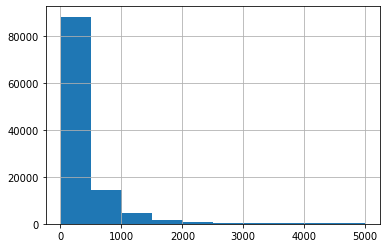

In [12]:
lens.hist();

In the code below, `re.compile(f'...')` compiles the expression `([{string.punctuation}...])` into pattern objects and the `f'...'` prefix causes the formatted string literal (f-string) `{string.punctuation}` to be evaluated at run-time. `string.punctuation` is a string that already contains common punctuation marks.

Then `re_tok.sub(r' \1 ', s)` finds all the matching punctuations and adds a prefix and suffix of white-spaces. Lastly, `split()` tokenizes strings into an array of individual words and punctuation marks.

In [13]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In the `vec` object below :

* strip_accents : Remove accents and perform other character normalization during the preprocessing step.

* ngram_range : The lower and upper boundary of the range of n-values for different n-grams to be extracted. For example an ``ngram_range`` of ``(1, 1)`` means only unigrams, ``(1, 2)`` means unigrams and bigrams, and ``(2, 2)`` means only bigrams.

* max_df : When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts.

* min_df : When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts.

* use_idfbool : Enable inverse-document-frequency reweighting.

* smooth_idfbool : Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.

* sublinear_tfbool : Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).



In [14]:
n = train.shape[0]

vec = TfidfVectorizer(strip_accents='unicode', ngram_range=(1,2), tokenizer=tokenize,
               max_df=0.8, min_df=2, use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
x_train = vec.fit_transform(train.comment_text)
x_valid = vec.transform(valid.comment_text)

In [15]:
x_train

<111699x524117 sparse matrix of type '<class 'numpy.float64'>'
	with 12576331 stored elements in Compressed Sparse Row format>

## NB-SVM Model

For more information, please have a look at : https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf

We define the log-count ratio $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents.

In [16]:
# for y_i = 1, computes the ratio of feature f in positive documents. Same applies for negative document, if y_i = 0.
def pr(y_i, y, x):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [17]:
# We fit a new model for one of every 6 features, one after the other
def get_model(y, x):
    y = y.values
    r = np.log(pr(1,y,x) / pr(0,y,x))
    m = LogisticRegression(C=4, dual=True, penalty='l2', solver='liblinear')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [18]:
preds = np.zeros((len(valid), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_model(train[j], x_train)
    preds[:,i] = m.predict_proba(x_valid.multiply(r))[:,1]

fit toxic
fit severe_toxic


C:\Users\acer\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit obscene
fit threat


C:\Users\acer\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit insult


C:\Users\acer\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit identity_hate


C:\Users\acer\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [19]:
preds = np.around(preds)

In [20]:
preds

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [21]:
val = valid.iloc[:,2:].to_numpy()

In [22]:
(preds == val).mean()

0.9830137310606061